In [1]:
from math import ceil, log
from functools import reduce
import re

from scipy.stats import linregress as linear_regression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.precision", 16)


In [2]:
class DBMeta(object):
    
    def __init__(self, T, K, Z, B, E, bpe, L, phi=1):
        self.T = int(T)
        self.K = int(K)
        self.Z = int(Z)
        self.B = int(B)
        self.E = int(E)
        self.bpe = bpe
        self.L = int(L)
        self.phi = phi
        if (K == T - 1):
            self.is_tiering = True
        else:
            self.is_tiering = False
        self.N = self.estimate_N()
        self.mfilt = int(self.bpe * self.N) >> 3
            
    def estimate_N(self):
        num_entries = 0
        for level in range(1, int(self.L) + 1):
            num_entries += (self.B / self.E) * (self.T - 1) * (self.T ** (level - 1))
        
        return num_entries
        
    def level(self):
        
        return ceil(log((self.N * self.E) / self.B + 1, self.T))     
    
    def write_cost(self):
        cost = self.T * (1 + self.phi) * (self.L / 8)
        if (self.is_tiering):
            cost = cost / self.T
        else:
            cost = cost / 2
            
        return cost
    
    def fp(self, curr_level):
        alpha = (self.T ** (self.T / (self.T - 1))) / (self.T ** (self.L + 1 - curr_level))
        return alpha * (np.e ** (-1 * self.mfilt * (np.log(2) ** 2) / self.N))
    
    def non_empty_read_cost(self):
        cost = 0
        run_probs = [self.B * (self.T ** (i)) / (self.E * self.N) for i in range(0, self.L)]
        fp_levels = [self.fp(i + 1) for i in range(0, self.L)]
        fp_levels_sum = [0] + list(np.cumsum(fp_levels))
        if self.is_tiering:
            for i in range(0, self.L):
                for r in range(1, self.T):
                    cost += run_probs[i] * (1 + (self.T - 1) * fp_levels_sum[i] + (r - 1) * fp_levels[i])
        else:
            for i in range(0 , self.L):
                cost += (self.T - 1) * run_probs[i] * (1 + fp_levels_sum[i])

        return cost
        
    def old_non_empty_read_cost(self):
        cost = 1 + self.empty_read_cost() 
        sub = np.e ** ((-1 * self.mfilt * (np.log(2) ** 2) / (self.N * self.L)) + (1 / (self.L * (self.T - 1))))
        if self.is_tiering:
            sub *= (self.T / (2 * (self.T - 1)))
        cost -= sub
        
        return cost
    
    def empty_read_cost(self):
        if self.is_tiering:
            alpha = self.T ** (self.T / (self.T - 1))
        else:
            alpha = (self.T ** (self.T / (self.T - 1))) / (self.T - 1)
        
        beta = np.e ** (-1 * self.mfilt * (np.log(2) ** 2) / self.N)
         
        return alpha * beta

    def dost_write_cost(self):
         
        return (1 / self.B) * (((self.T - 1) * (self.level() - 1) / (self.K + 1)) + (self.T - 1) / (self.Z + 1))

In [3]:
def set_style():
    # This sets reasonable defaults for font size for a paper
    sns.set_context("paper")    
    # Set the font to be serif
    sns.set(font='serif')#, rc={'text.usetex' : True})   
    # Make the background white, and specify the specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
    # Set tick size for axes
    sns.set_style("ticks", {"xtick.major.size": 6, "ytick.major.size": 6})
    
    fsz = 14
    plt.rc('font', size=fsz)
    plt.rc('axes', titlesize=fsz)
    plt.rc('axes', labelsize=fsz)
    plt.rc('xtick', labelsize=fsz)
    plt.rc('ytick', labelsize=fsz)
    plt.rc('legend', fontsize=fsz)
    plt.rc('figure', titlesize=fsz)
    
def read_data(file_path): 
    df = pd.read_csv(file_path)
    df['model_write_cost'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['L']).write_cost(), axis=1)
    df['dost_write_cost'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['L']).dost_write_cost(), axis=1)
    df['estimated_levels'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['L']).level(), axis=1)
    df['model_non_empty_read_cost'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['L']).non_empty_read_cost(), axis=1)
    df['old_non_empty_read_cost'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['L']).old_non_empty_read_cost(), axis=1)
    df['model_empty_read_cost'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['L']).empty_read_cost(), axis=1)
    df['measured_non_empty_read_cost'] = df['valid_read_time'] / df['num_non_empty_reads']
    df['measured_empty_read_cost'] = df['empty_read_time'] / df['num_empty_reads']
    df['measured_write_cost'] = df['write_time'] / df['num_writes']
    
    return df

In [4]:
def plot_cost_ratio(df, x='bpe', y='non_empty_read', err=False):
    is_tiering = True if df.iloc[-1]['K'] == df.iloc[-1]['T'] - 1 else False
    fig, ax1 = plt.subplots(figsize=(15,5))
    
    color = 'black'
    ax1.set_xlabel(x)
    ax1.set_ylabel(f'Avg ms per {y}')
    ax1.plot(df[x], df['measured_' + y + '_cost'], color=color)
    if err:
        ax1.errorbar(df[x], df['measured_' + y + '_cost'], yerr=df[y + '_std'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(bottom=0)

    color = 'red'
    ax2 = ax1.twinx()
    ax2.set_ylabel('Model Cost', color=color)
    ax2.plot(df[x], df['model_' + y + '_cost'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(bottom=0)
    
    B, E, num_writes = df.iloc[-1][['B', 'E', 'num_' + y + 's']]
    title = [
        'Policy: {}'.format('Tiering' if is_tiering else 'Leveling'),
        'Buffer Size: {} MB'.format(B / (1 << 20)),
        'Entry Size: {} KB'.format(E / (1 << 10)),
        '{}s: {} million (~ {:.2f} GB)'.format(y, int(num_writes / 1e6), int(num_writes) * E / (1 << 30))
    ]
        
    ax1.set_title('\n'.join(title))
    
    return fig

def plot_diff(df1, df2, x='bpe', y='non_empty_read'):
    fig, ax1 = plt.subplots(figsize=(15,5))
    
    is_tiering_1 = True if df1.iloc[-1]['K'] == df1.iloc[-1]['T'] - 1 else False
    is_tiering_2 = True if df2.iloc[-1]['K'] == df2.iloc[-1]['T'] - 1 else False
    label1 = 'Model Tier' if is_tiering_1 else 'Model Level'
    label2 = 'Model Tier' if is_tiering_2 else 'Model Level'
    
    ax1.set_xlabel(x)
    ax1.set_ylabel(f'Avg ms per {y}')
    ax1.plot(df1[x], df1['measured_' + y + '_cost'], label='Tier' if is_tiering_1 else 'Level')
    ax1.plot(df2[x], df2['measured_' + y + '_cost'], label='Tier' if is_tiering_2 else 'Level')
    ax1.set_ylim(bottom=0)
    
    B, E, num_writes = df1.iloc[-1][['B', 'E', 'num_' + y + 's']]
    title = [
        'Buffer Size: {} MB'.format(B / (1 << 20)),
        'Entry Size: {} KB'.format(E / (1 << 10)),
        'Writes: {} million (~ {:.2f} GB)'.format(int(num_writes / 1e6), int(num_writes) * E / (1 << 30))
    ]
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Model Cost')
    ax2.plot(df1[x], df1['model_'+ y + '_cost'], '--')
    ax2.plot(df2[x], df2['model_'+ y + '_cost'], '--')
    ax2.legend([label1, label2])
    ax2.set_ylim(bottom=0)

    
    ax1.set_title('\n'.join(title))
    
    return fig 

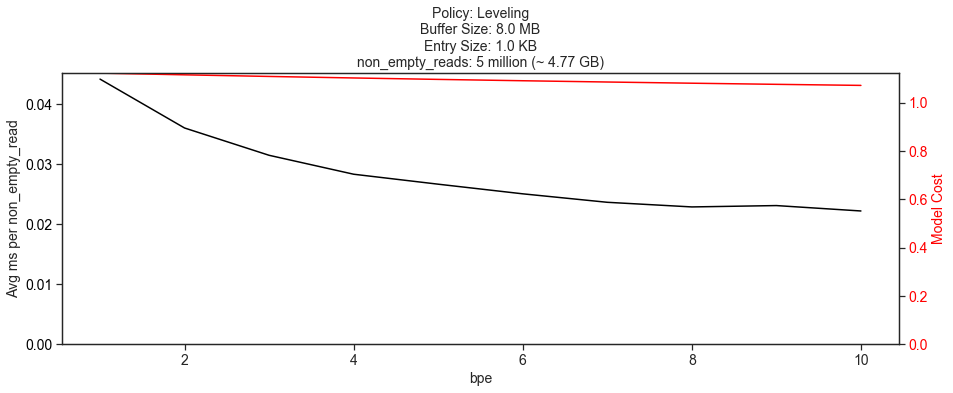

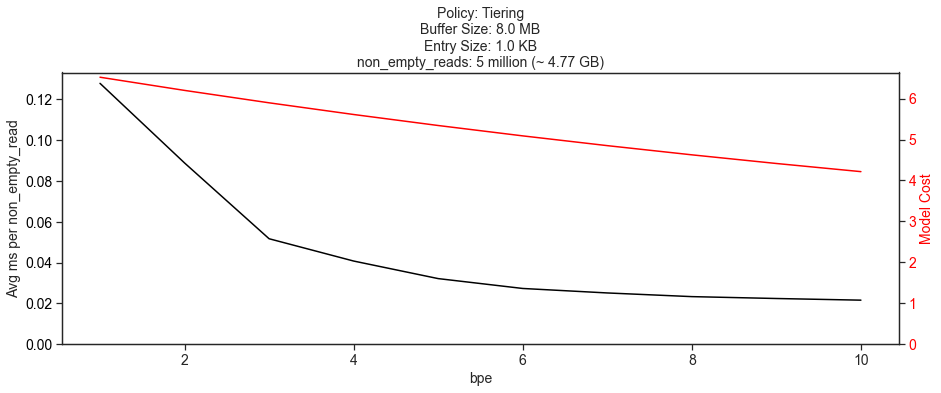

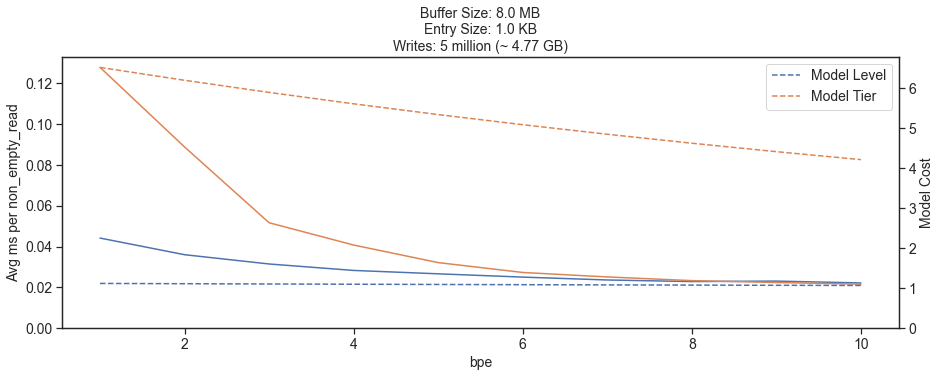

In [5]:
set_style()

df1 = read_data('../../data/bpe_cost/1.csv')
_ = plot_cost_ratio(df1)

df2 = read_data('../../data/bpe_cost/2.csv')
_ = plot_cost_ratio(df2)

_ = plot_diff(df1, df2)

In [6]:
df1

,T,K,Z,B,E,bpe,L,num_writes,num_non_empty_reads,num_empty_reads,...,empty_read_time,model_write_cost,dost_write_cost,estimated_levels,model_non_empty_read_cost,old_non_empty_read_cost,model_empty_read_cost,measured_non_empty_read_cost,measured_empty_read_cost,measured_write_cost
0,10,1,1,8388608,1024,1,3,0,5000000,5000000,...,189499.0000000000000000,3.75,0.0000016093254089,3,1.1216266792700398,1.3342437521107497,1.3514075474448863,0.04418340,0.03789980,-inf
1,10,1,1,8388608,1024,2,3,0,5000000,5000000,...,120554.6000000000058208,3.75,0.0000016093254089,3,1.1145372068219046,1.2756318478345219,1.2726356313544942,0.03603752,0.02411092,-inf
2,10,1,1,8388608,1024,3,3,0,5000000,5000000,...,78228.8000000000029104,3.75,0.0000016093254089,3,1.1078609711725909,1.2212118955717732,1.1984552352510103,0.03148836,0.01564576,-inf
3,10,1,1,8388608,1024,4,3,0,5000000,5000000,...,52126.1999999999970896,3.75,0.0000016093254089,3,1.1015738852474752,1.1707241805286608,1.1285987249719496,0.02833492,0.01042524,-inf
4,10,1,1,8388608,1024,5,3,0,5000000,5000000,...,35109.1999999999970896,3.75,0.0000016093254089,3,1.0956532659784644,1.1239244310233694,1.0628140664273815,0.02667444,0.00702184,-inf
5,10,1,1,8388608,1024,6,3,0,5000000,5000000,...,24059.0000000000000000,3.75,0.0000016093254089,3,1.0900777524661462,1.0805829122876267,1.0008639162905144,0.02506928,0.00481180,-inf
6,10,1,1,8388608,1024,7,3,0,5000000,5000000,...,17012.7999999999992724,3.75,0.0000016093254089,3,1.0848272289121748,1.0404835732091087,0.9425247656908297,0.02365784,0.00340256,-inf
7,10,1,1,8388608,1024,8,3,0,5000000,5000000,...,12979.6000000000003638,3.75,0.0000016093254089,3,1.0798827520438281,1.0034232429265080,0.8875861338203114,0.02288628,0.00259592,-inf
8,10,1,1,8388608,1024,9,3,0,5000000,5000000,...,10650.7999999999992724,3.75,0.0000016093254089,3,1.0752264827689055,0.9692108743690784,0.8358498085433945,0.02311212,0.00213016,-inf
9,10,1,1,8388608,1024,10,3,0,5000000,5000000,...,8826.3999999999996362,3.75,0.0000016093254089,3,1.0708416218143759,0.9376668320020498,0.7871291312708444,0.02221180,0.00176528,-inf
